In [ ]:
# pip install keras

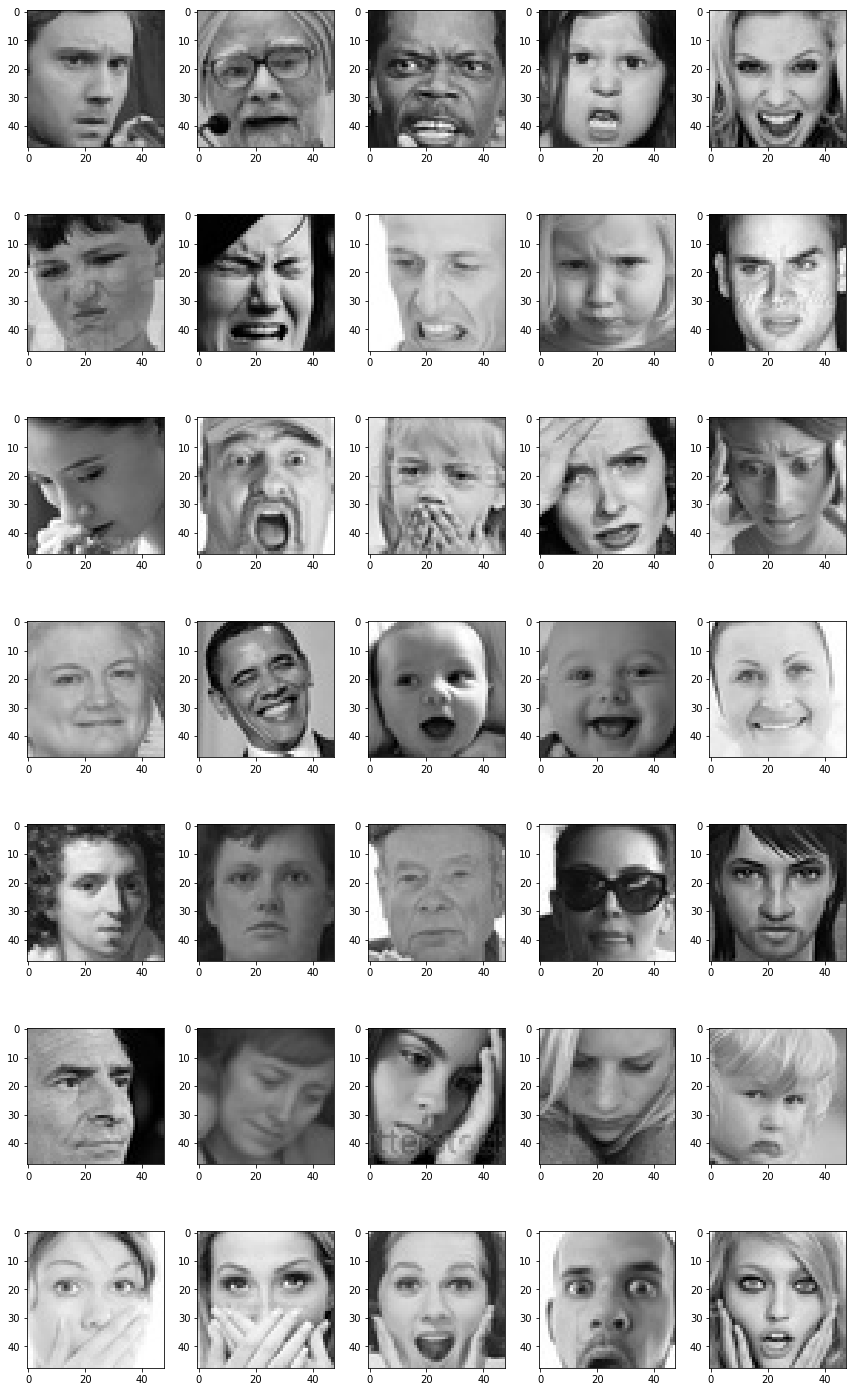

In [2]:
# load the data
import numpy as np
import seaborn as sns
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt;
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"
# size of the pic
pic_size = 48

# base path
base_path = "./images/"

plt.figure(0, figsize=(12,20))
cpt = 0

for expression in os.listdir(base_path + "train/"):
    for i in range(5):
        cpt = cpt + 1
        plt.subplot(7,5,cpt)
        img = load_img(base_path + "train/" + expression + "/" + os.listdir(base_path + "train/" + expression)[i], target_size=(pic_size, pic_size))
        plt.imshow(img, cmap="gray")

plt.tight_layout()
plt.show() 

In [3]:
# check the number of pictures
for expression in os.listdir(base_path + "train"):
    print(str(len(os.listdir(base_path + "train/" + expression))) + " " + expression + " images")

3993 angry images
436 disgust images
4103 fear images
7164 happy images
4982 neutral images
4938 sad images
3205 surprise images


In [4]:
# split data.
# 4 convolutional layers
# 2 fully connected layers
from keras.preprocessing.image import ImageDataGenerator
# number of images to feed into the NN for every batch
batch_size = 128

datagen_train = ImageDataGenerator()
datagen_validation = ImageDataGenerator()

train_generator = datagen_train.flow_from_directory(base_path + "train",
                                                    target_size=(pic_size,pic_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = datagen_validation.flow_from_directory(base_path + "validation",
                                                    target_size=(pic_size,pic_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)


Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [5]:
# setup CNN
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam

# number of possible label values
nb_classes = 7

# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(nb_classes, activation='softmax'))

opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
%%time
# train the model

# number of epochs to train the NN
epochs = 10

from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit_generator(generator=train_generator,
                                steps_per_epoch=train_generator.n//train_generator.batch_size,
                                epochs=epochs,
                                validation_data = validation_generator,
                                validation_steps = validation_generator.n//validation_generator.batch_size,
                                callbacks=callbacks_list
                                )

Epoch 1/10
225/225 [==============================] - 628s 3s/step - loss: 2.0148 - accuracy: 0.2372 - val_loss: 2.2103 - val_accuracy: 0.3212
Epoch 2/10


C:\Users\Asus\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


225/225 [==============================] - 625s 3s/step - loss: 1.8136 - accuracy: 0.3018 - val_loss: 2.2234 - val_accuracy: 0.3489
Epoch 3/10
225/225 [==============================] - 624s 3s/step - loss: 1.7171 - accuracy: 0.3406 - val_loss: 2.1459 - val_accuracy: 0.3595
Epoch 4/10
225/225 [==============================] - 651s 3s/step - loss: 1.6381 - accuracy: 0.3725 - val_loss: 2.1738 - val_accuracy: 0.3980
Epoch 5/10
225/225 [==============================] - 688s 3s/step - loss: 1.5779 - accuracy: 0.3915 - val_loss: 2.5388 - val_accuracy: 0.3951
Epoch 6/10
225/225 [==============================] - 692s 3s/step - loss: 1.5254 - accuracy: 0.4145 - val_loss: 1.8342 - val_accuracy: 0.4392
Epoch 7/10
225/225 [==============================] - 695s 3s/step - loss: 1.4825 - accuracy: 0.4327 - val_loss: 1.7937 - val_accuracy: 0.4563
Epoch 8/10
225/225 [==============================] - 691s 3s/step - loss: 1.4359 - accuracy: 0.4477 - val_loss: 1.4656 - val_accuracy: 0.4705
Epoch 9/10

In [7]:
# serialize model structure to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

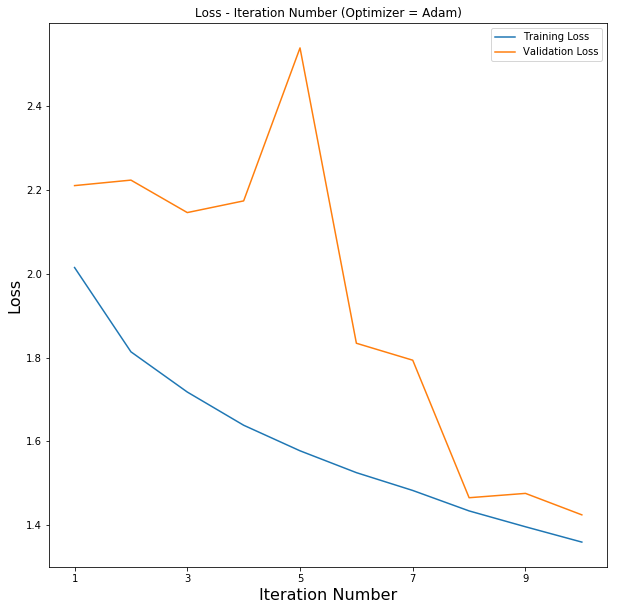

In [115]:
# plot the evolution of Loss on the train and validation sets

import matplotlib.pyplot as plt

xlabel = [""+str(2 * x + 1) for x in range(10)]
plt.figure(figsize=(10,10))
plt.xticks(np.arange(0, epochs + 2, step=2) , tuple(xlabel))
plt.title('Loss - Iteration Number (Optimizer = Adam)')
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Iteration Number', fontsize = 16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

[ 2  4  6  8 10]
[0.23723556, 0.3017809, 0.34064057, 0.37249503, 0.39145437, 0.4145262, 0.43271878, 0.44773987, 0.46520057, 0.4809187]


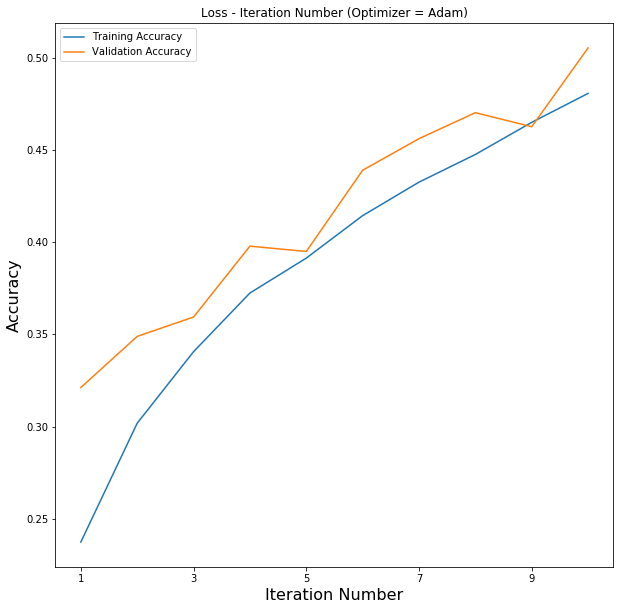

In [116]:
# plot the evolution of Accuracy on the train and validation sets
xlabel = [""+str(2 * x + 1) for x in range(10)]
plt.figure(figsize=(10,10))
plt.xticks(np.arange(0, epochs + 2, step=2) , tuple(xlabel))
print(np.arange(2, epochs + 2, step=2))
plt.title('Loss - Iteration Number (Optimizer = Adam)')
plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Iteration Number', fontsize = 16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
print(history.history['accuracy'])
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='upper left')
plt.show()

In [1]:
# show the confusion matrix of our predictions

# compute predictions
predictions = model.predict_generator(generator=validation_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = validation_generator.classes
class_names = validation_generator.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

NameError: name 'model' is not defined

In [66]:
# testing.
filenames=validation_generator.filenames
classes = ["angry", "disgust", "fear","happy","neutral","sad","surprise"]
print("file name is :" , filenames[0])
print("number of files are :", str(len(filenames)))
print("classes are :", str(class_names))
print("first prediction is :", str(predictions[0]))
print("length of y_test :", str(len(y_test)))
print("length of y_pred :", str(len(y_pred)))
print("first test class is :", str(y_test[0]))
print("first pred class is :", str(y_pred[0]))

file name is : angry\10052.jpg
number of files are : 7066
classes are : dict_keys(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])
first prediction is : [0.45 0.03 0.08 0.11 0.09 0.24 0.01]
length of y_test : 7066
length of y_pred : 7066
first test class is : 0
first pred class is : 0


In [76]:
# get 5 true predictions of "angry" picture
# get 5 false predictions of "angry" picture
true_angry_path = []
false_angry_path = []
false_angry_class = []
count = 0
iterate = 0
while count != 10:
    if y_test[iterate] == 0 and y_test[iterate] == y_pred[iterate] and len(true_angry_path) != 5:
        true_angry_path.append(filenames[iterate])
        count += 1
    else:
        if y_test[iterate] == 0 and y_test[iterate] != y_pred[iterate] and len(false_angry_path) != 5:
            false_angry_path.append(filenames[iterate])
            false_angry_class.append(y_pred[iterate])
            count += 1
    iterate += 1

print(true_angry_path)
print(false_angry_path)
print(false_angry_class)

['angry\\10052.jpg', 'angry\\10079.jpg', 'angry\\10095.jpg', 'angry\\10121.jpg', 'angry\\10148.jpg']
['angry\\10065.jpg', 'angry\\10163.jpg', 'angry\\1024.jpg', 'angry\\10336.jpg', 'angry\\10338.jpg']
[5, 3, 3, 3, 3]


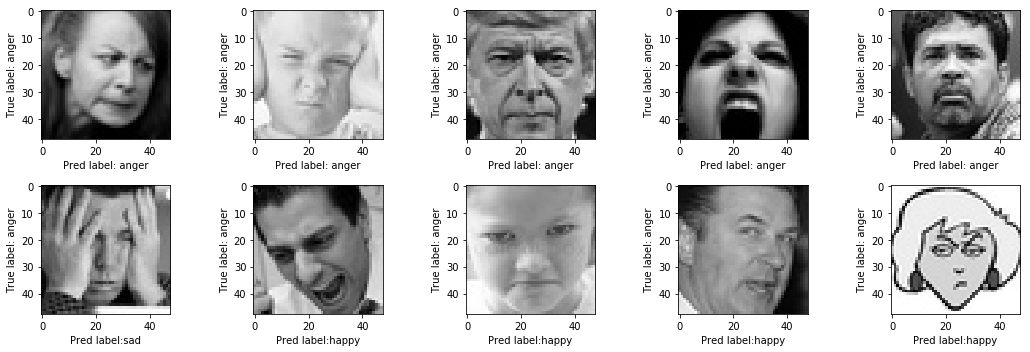

In [80]:
# plot 5 true predictions of "angry" picture
# plot 5 false predictions of "angry" picture

plt.figure(0, figsize=(15,5))
cpt = 0
true_count = 0
false_count = 0
for i in range(2):
    for j in range(5):
        cpt = cpt + 1
        plt.subplot(2,5,cpt)
        plt.ylabel("True label: " + "anger")
        if i == 0:
            img = load_img(base_path + "validation/" +true_angry_path[true_count].replace("\\","/"), target_size=(pic_size, pic_size))
            plt.xlabel("Pred label: " + "anger")
            true_count += 1
        else:
            img = load_img(base_path + "validation/" +false_angry_path[false_count].replace("\\","/"), target_size=(pic_size, pic_size))
            plt.xlabel("Pred label:" + classes[false_angry_class[false_count]])
            false_count += 1           

        plt.imshow(img, cmap="gray")

plt.tight_layout()
plt.show() 

In [88]:
# get 5 true predictions of "disgust" picture
# get 5 false predictions of "disgust" picture
true_disgust_path = []
false_disgust_path = []
false_disgust_class = []
count = 0
iterate = 0
while count != 10:
    if y_test[iterate] == 1 and y_test[iterate] == y_pred[iterate] and len(true_disgust_path) != 5:
        true_disgust_path.append(filenames[iterate])
        count += 1
    else:
        if y_test[iterate] == 1 and y_test[iterate] != y_pred[iterate] and len(false_disgust_path) != 5:
            false_disgust_path.append(filenames[iterate])
            false_disgust_class.append(y_pred[iterate])
            count += 1
    iterate += 1

print(true_disgust_path)
print(false_disgust_path)
print(false_disgust_class)

['disgust\\1115.jpg', 'disgust\\11529.jpg', 'disgust\\11639.jpg', 'disgust\\12753.jpg', 'disgust\\18464.jpg']
['disgust\\10053.jpg', 'disgust\\10435.jpg', 'disgust\\10532.jpg', 'disgust\\11222.jpg', 'disgust\\12417.jpg']
[0, 5, 4, 0, 5]


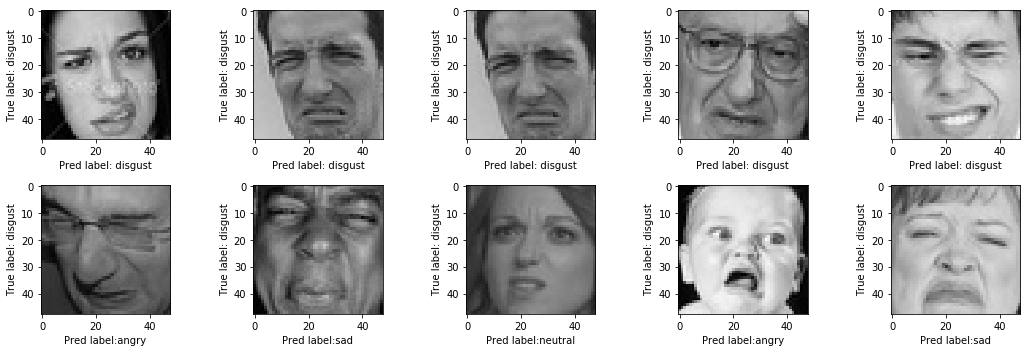

In [89]:
# plot 5 true predictions of "disgust" picture
# plot 5 false predictions of "disgust" picture

plt.figure(0, figsize=(15,5))
cpt = 0
true_count = 0
false_count = 0
for i in range(2):
    for j in range(5):
        cpt = cpt + 1
        plt.subplot(2,5,cpt)
        plt.ylabel("True label: " + "disgust")
        if i == 0:
            img = load_img(base_path + "validation/" +true_disgust_path[true_count].replace("\\","/"), target_size=(pic_size, pic_size))
            plt.xlabel("Pred label: " + "disgust")
            true_count += 1
        else:
            img = load_img(base_path + "validation/" +false_disgust_path[false_count].replace("\\","/"), target_size=(pic_size, pic_size))
            plt.xlabel("Pred label:" + classes[false_disgust_class[false_count]])
            false_count += 1           

        plt.imshow(img, cmap="gray")

plt.tight_layout()
plt.show() 

In [91]:
# get 5 true predictions of "fear" picture
# get 5 false predictions of "fear" picture
true_fear_path = []
false_fear_path = []
false_fear_class = []
count = 0
iterate = 0
while count != 10:
    if y_test[iterate] == 2 and y_test[iterate] == y_pred[iterate] and len(true_fear_path) != 5:
        true_fear_path.append(filenames[iterate])
        count += 1
    else:
        if y_test[iterate] == 2 and y_test[iterate] != y_pred[iterate] and len(false_fear_path) != 5:
            false_fear_path.append(filenames[iterate])
            false_fear_class.append(y_pred[iterate])
            count += 1
    iterate += 1

print(true_fear_path)
print(false_fear_path)
print(false_fear_class)

['fear\\10355.jpg', 'fear\\11471.jpg', 'fear\\11536.jpg', 'fear\\11682.jpg', 'fear\\11968.jpg']
['fear\\10029.jpg', 'fear\\10043.jpg', 'fear\\10044.jpg', 'fear\\1008.jpg', 'fear\\10099.jpg']
[6, 5, 5, 0, 4]


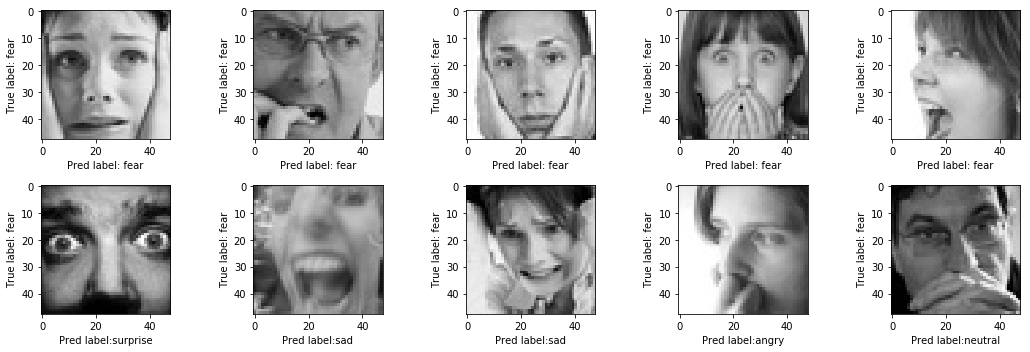

In [92]:
# plot 5 true predictions of "fear" picture
# plot 5 false predictions of "fear" picture

plt.figure(0, figsize=(15,5))
cpt = 0
true_count = 0
false_count = 0
for i in range(2):
    for j in range(5):
        cpt = cpt + 1
        plt.subplot(2,5,cpt)
        plt.ylabel("True label: " + "fear")
        if i == 0:
            img = load_img(base_path + "validation/" +true_fear_path[true_count].replace("\\","/"), target_size=(pic_size, pic_size))
            plt.xlabel("Pred label: " + "fear")
            true_count += 1
        else:
            img = load_img(base_path + "validation/" +false_fear_path[false_count].replace("\\","/"), target_size=(pic_size, pic_size))
            plt.xlabel("Pred label:" + classes[false_fear_class[false_count]])
            false_count += 1           

        plt.imshow(img, cmap="gray")

plt.tight_layout()
plt.show() 

In [94]:
# get 5 true predictions of "happy" picture
# get 5 false predictions of "happy" picture
true_happy_path = []
false_happy_path = []
false_happy_class = []
count = 0
iterate = 0
while count != 10:
    if y_test[iterate] == 3 and y_test[iterate] == y_pred[iterate] and len(true_happy_path) != 5:
        true_happy_path.append(filenames[iterate])
        count += 1
    else:
        if y_test[iterate] == 3 and y_test[iterate] != y_pred[iterate] and len(false_happy_path) != 5:
            false_happy_path.append(filenames[iterate])
            false_happy_class.append(y_pred[iterate])
            count += 1
    iterate += 1

print(true_happy_path)
print(false_happy_path)
print(false_happy_class)

['happy\\10074.jpg', 'happy\\10096.jpg', 'happy\\10106.jpg', 'happy\\10126.jpg', 'happy\\10138.jpg']
['happy\\10019.jpg', 'happy\\10023.jpg', 'happy\\10141.jpg', 'happy\\10273.jpg', 'happy\\10456.jpg']
[5, 5, 6, 4, 0]


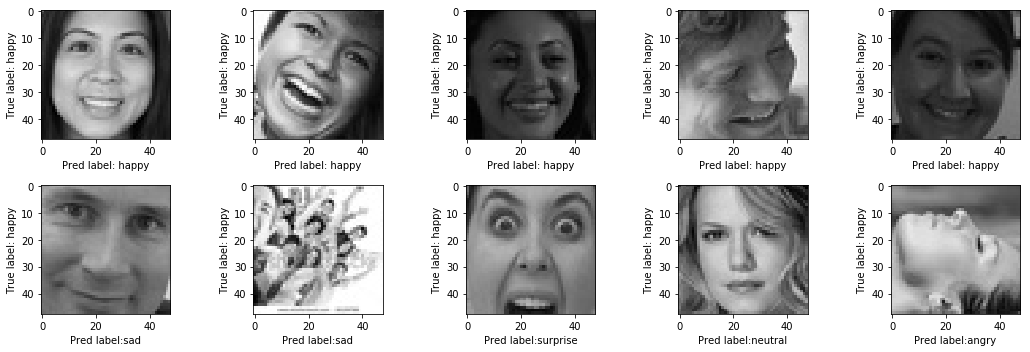

In [95]:
# plot 5 true predictions of "happy" picture
# plot 5 false predictions of "happy" picture

plt.figure(0, figsize=(15,5))
cpt = 0
true_count = 0
false_count = 0
for i in range(2):
    for j in range(5):
        cpt = cpt + 1
        plt.subplot(2,5,cpt)
        plt.ylabel("True label: " + "happy")
        if i == 0:
            img = load_img(base_path + "validation/" +true_happy_path[true_count].replace("\\","/"), target_size=(pic_size, pic_size))
            plt.xlabel("Pred label: " + "happy")
            true_count += 1
        else:
            img = load_img(base_path + "validation/" +false_happy_path[false_count].replace("\\","/"), target_size=(pic_size, pic_size))
            plt.xlabel("Pred label:" + classes[false_happy_class[false_count]])
            false_count += 1           

        plt.imshow(img, cmap="gray")

plt.tight_layout()
plt.show() 

In [97]:
# get 5 true predictions of "neutral" picture
# get 5 false predictions of "neutral" picture
true_neutral_path = []
false_neutral_path = []
false_neutral_class = []
count = 0
iterate = 0
while count != 10:
    if y_test[iterate] == 4 and y_test[iterate] == y_pred[iterate] and len(true_neutral_path) != 5:
        true_neutral_path.append(filenames[iterate])
        count += 1
    else:
        if y_test[iterate] == 4 and y_test[iterate] != y_pred[iterate] and len(false_neutral_path) != 5:
            false_neutral_path.append(filenames[iterate])
            false_neutral_class.append(y_pred[iterate])
            count += 1
    iterate += 1

print(true_neutral_path)
print(false_neutral_path)
print(false_neutral_class)

['neutral\\10033.jpg', 'neutral\\10068.jpg', 'neutral\\10134.jpg', 'neutral\\10266.jpg', 'neutral\\10346.jpg']
['neutral\\10048.jpg', 'neutral\\10117.jpg', 'neutral\\10118.jpg', 'neutral\\10150.jpg', 'neutral\\10247.jpg']
[3, 5, 5, 3, 0]


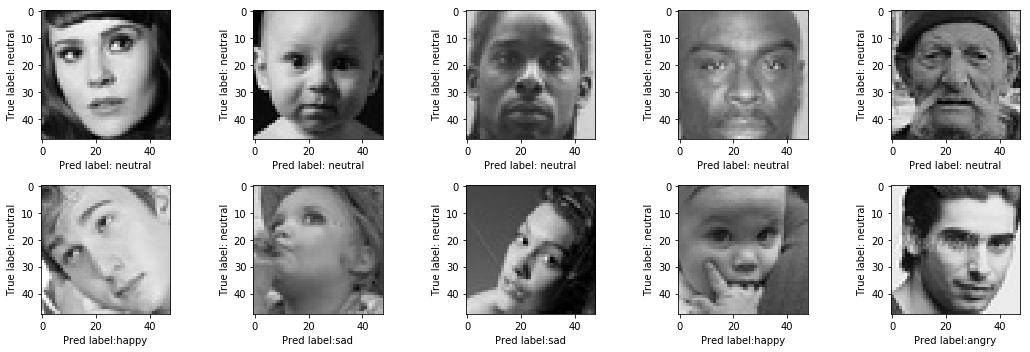

In [98]:
# plot 5 true predictions of "neutral" picture
# plot 5 false predictions of "neutral" picture

plt.figure(0, figsize=(15,5))
cpt = 0
true_count = 0
false_count = 0
for i in range(2):
    for j in range(5):
        cpt = cpt + 1
        plt.subplot(2,5,cpt)
        plt.ylabel("True label: " + "neutral")
        if i == 0:
            img = load_img(base_path + "validation/" +true_neutral_path[true_count].replace("\\","/"), target_size=(pic_size, pic_size))
            plt.xlabel("Pred label: " + "neutral")
            true_count += 1
        else:
            img = load_img(base_path + "validation/" +false_neutral_path[false_count].replace("\\","/"), target_size=(pic_size, pic_size))
            plt.xlabel("Pred label:" + classes[false_neutral_class[false_count]])
            false_count += 1           

        plt.imshow(img, cmap="gray")

plt.tight_layout()
plt.show() 

In [100]:
# get 5 true predictions of "sad" picture
# get 5 false predictions of "sad" picture
true_sad_path = []
false_sad_path = []
false_sad_class = []
count = 0
iterate = 0
while count != 10:
    if y_test[iterate] == 5 and y_test[iterate] == y_pred[iterate] and len(true_sad_path) != 5:
        true_sad_path.append(filenames[iterate])
        count += 1
    else:
        if y_test[iterate] == 5 and y_test[iterate] != y_pred[iterate] and len(false_sad_path) != 5:
            false_sad_path.append(filenames[iterate])
            false_sad_class.append(y_pred[iterate])
            count += 1
    iterate += 1

print(true_sad_path)
print(false_sad_path)
print(false_sad_class)

['sad\\10004.jpg', 'sad\\10031.jpg', 'sad\\1022.jpg', 'sad\\10252.jpg', 'sad\\1026.jpg']
['sad\\1003.jpg', 'sad\\10073.jpg', 'sad\\10114.jpg', 'sad\\10116.jpg', 'sad\\10171.jpg']
[4, 4, 2, 2, 4]


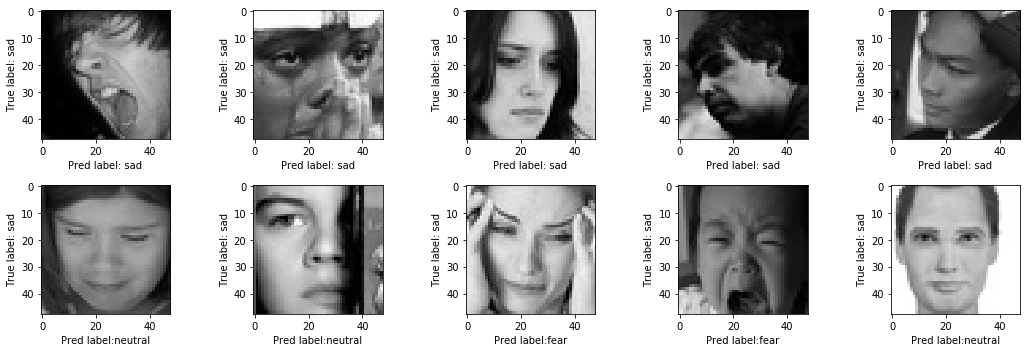

In [101]:
# plot 5 true predictions of "sad" picture
# plot 5 false predictions of "sad" picture

plt.figure(0, figsize=(15,5))
cpt = 0
true_count = 0
false_count = 0
for i in range(2):
    for j in range(5):
        cpt = cpt + 1
        plt.subplot(2,5,cpt)
        plt.ylabel("True label: " + "sad")
        if i == 0:
            img = load_img(base_path + "validation/" +true_sad_path[true_count].replace("\\","/"), target_size=(pic_size, pic_size))
            plt.xlabel("Pred label: " + "sad")
            true_count += 1
        else:
            img = load_img(base_path + "validation/" +false_sad_path[false_count].replace("\\","/"), target_size=(pic_size, pic_size))
            plt.xlabel("Pred label:" + classes[false_sad_class[false_count]])
            false_count += 1           

        plt.imshow(img, cmap="gray")

plt.tight_layout()
plt.show() 

In [103]:
# get 5 true predictions of "surprise" picture
# get 5 false predictions of "surprise" picture
true_surprise_path = []
false_surprise_path = []
false_surprise_class = []
count = 0
iterate = 0
while count != 10:
    if y_test[iterate] == 6 and y_test[iterate] == y_pred[iterate] and len(true_surprise_path) != 5:
        true_surprise_path.append(filenames[iterate])
        count += 1
    else:
        if y_test[iterate] == 6 and y_test[iterate] != y_pred[iterate] and len(false_surprise_path) != 5:
            false_surprise_path.append(filenames[iterate])
            false_surprise_class.append(y_pred[iterate])
            count += 1
    iterate += 1

print(true_surprise_path)
print(false_surprise_path)
print(false_surprise_class)

['surprise\\10056.jpg', 'surprise\\10185.jpg', 'surprise\\10259.jpg', 'surprise\\1033.jpg', 'surprise\\10365.jpg']
['surprise\\10097.jpg', 'surprise\\10162.jpg', 'surprise\\10246.jpg', 'surprise\\10268.jpg', 'surprise\\10306.jpg']
[4, 4, 4, 3, 2]


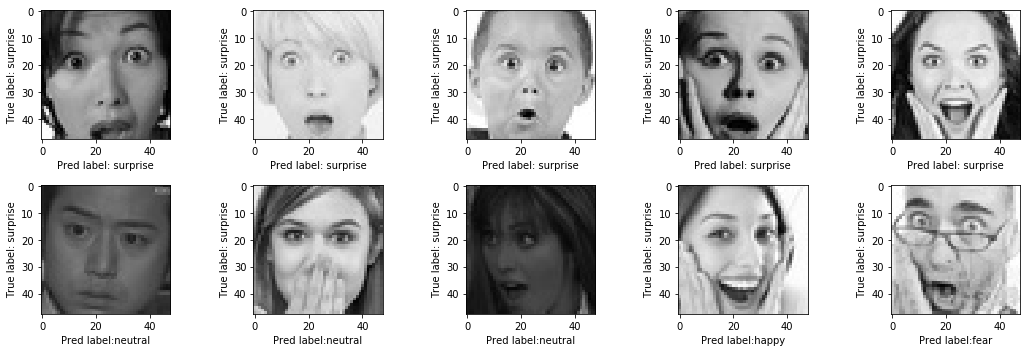

In [104]:
# plot 5 true predictions of "surprise" picture
# plot 5 false predictions of "surprise" picture

plt.figure(0, figsize=(15,5))
cpt = 0
true_count = 0
false_count = 0
for i in range(2):
    for j in range(5):
        cpt = cpt + 1
        plt.subplot(2,5,cpt)
        plt.ylabel("True label: " + "surprise")
        if i == 0:
            img = load_img(base_path + "validation/" +true_surprise_path[true_count].replace("\\","/"), target_size=(pic_size, pic_size))
            plt.xlabel("Pred label: " + "surprise")
            true_count += 1
        else:
            img = load_img(base_path + "validation/" +false_surprise_path[false_count].replace("\\","/"), target_size=(pic_size, pic_size))
            plt.xlabel("Pred label:" + classes[false_surprise_class[false_count]])
            false_count += 1           

        plt.imshow(img, cmap="gray")

plt.tight_layout()
plt.show() 